In [1]:
from astropy.io import fits
from astropy.time import Time
import argparse, sys, os, urllib.request, time, stat
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from tabulate import tabulate
import sqlite3

# The following parameters are set this way so that the legend 
# is not cut off when the program is run from a terminal:

#from matplotlib import rcParams     
#rcParams.update({'figure.subplot.right': 0.73})
#rcParams.update({'figure.subplot.left': 0.15})
#rcParams.update({'figure.subplot.top': 0.89})
#rcParams.update({'figure.subplot.bottom': 0.22})

# For running in ipython notebook (comment out otherwise):
%matplotlib inline

In [ ]:
# This part not needed if running from ipython notebook
# When using ipython notebook, set RA, DEC, ERR manually

# We want the user to input the neutrino event's RA, DEC, and the radius of its error circle:

parser = argparse.ArgumentParser()
parser.add_argument('-r', '--RA', type = float, dest = 'RA', help = 'enter right ascension in degrees')
parser.add_argument('-d', '--DEC', type = float, dest = 'DEC', help = 'enter declination in degrees')
parser.add_argument('-e', '--ERR', type = float, dest = 'ERR', help = 'enter radius of the error circle in degrees')
parser.add_argument('-t', '--start', type = str, dest = 'start', help = "start time of event, format 'YYYY-MM-DD HH:MM:SS.SSS...'")
parser.add_argument('-s', '--stop', type = str, dest = 'stop', help = "end time of event, format 'YYYY-MM-DD HH:MM:SS.SSS...'")

args = parser.parse_args()

#Limit acceptable values of RA and DEC. 
#It's possible to do this in argparse but I haven't found a good way yet.

if not(0.0 <= args.RA <= 360.0):
   print('Error: Right Ascension should be between 0 and 360 degrees')
   sys.exit()
    
if not(-90.0 <= args.DEC <= 90.0):
   print('Error: Declination should be between -90 and 90 degrees')
   sys.exit()

if not(0.0 <= args.ERR <= 90.0):
   print('Error: Error should be between 0 and 90 degrees')
   sys.exit()

if(args.start > args.stop):
    print("Error: Event's end time should be after its start time.")
    sys.exit()

# Variables are easier to work with without the 'args.'

RA = args.RA
DEC = args.DEC
ERR = args.ERR
start = args.start
stop = args.stop

start = Time(start, format = 'iso', scale = 'utc')
stop = Time(stop, format = 'iso', scale = 'utc')

In [2]:
# This function plots the error circle of the neutrino event

def ploterrcirc(RA, DEC, ERR, RA1, RA2, DEC1, DEC2):

    fig = plt.figure(1, figsize=(7, 7))
    plt.axis([RA1, RA2, DEC1, DEC2])
    ax = fig.add_subplot(1, 1, 1)
    errcirc = plt.Circle((RA, DEC), radius = ERR, color = 'r', fill = False)
    ax.add_patch(errcirc)

    ticks = ax.get_xticks()
    ticks[ticks > 359.9999] -= 360
    ticks[ticks < 0.0] += 360
    ax.set_xticklabels([int(tick) for tick in ticks])

    plt.xlabel('RA (deg)', fontsize = 14)
    plt.ylabel('DEC (deg)', fontsize = 14)

    plt.plot(RA, DEC, 'x', color = 'r')

In [11]:
# This function reads downloads and data from fits files and sorts the sources by type
# It is called once per catalog, and requires some fine tuning based on 
# which catalog is being read

def readfits(URL, file_name, RA, DEC, RA1, RA2, DEC1, DEC2, ERR, marker):
    # Check if the catalog exists already. If not, download it from the website and save it:
    if((os.path.isfile(file_name) == False) and (URL != 'nope')):
        urllib.request.urlretrieve(URL, file_name)
    
    # Read data from file:
    hdulist = fits.open(file_name)
    tbdata = hdulist[1].data
    names = tbdata.field(0)
    if(marker == '3FGL'):
        RAs = tbdata.field(1)
        DECs = tbdata.field(2)
        classes = tbdata.field(73)
        eflux = tbdata.field(19)
        pflux = tbdata.field(17)
        rshift = np.zeros(len(names))
        rshift = rshift.astype('str')
    if(marker == '2FHL'):
        RAs = tbdata.field(1)
        DECs = tbdata.field(2)
        classes = tbdata.field(34)
        eflux = tbdata.field(16)
        pflux = tbdata.field(14)
        rshift = tbdata.field(35)
        rshift = rshift.astype('str')
    if(marker == '2FAV'):
        for i in range(len(names)):
            names[i] = '2FAV ' + names[i]
        RAs = tbdata.field(2)
        DECs = tbdata.field(3)
        classes = tbdata.field(13)
        eflux = np.zeros(len(names))
        pflux = np.zeros(len(names))
        rshift = np.zeros(len(names))
        rshift = rshift.astype('str')
    if(marker == 'ROSAT'):
        RAs = tbdata.field(1)
        DECs = tbdata.field(2)
        classes = np.full(len(names), 'AGN')
        eflux = tbdata.field(3)
        pflux = np.zeros(len(names))
        rshift = tbdata.field(4)
        rshift = rshift.astype('str')
    if(marker == 'XMM'):
        RAs = tbdata.field(1)
        DECs = tbdata.field(2)
        classes = np.full(len(names), 'AGN')
        eflux = tbdata.field(3)
        pflux = np.zeros(len(names))
        rshift = tbdata.field(4)
        rshift = rshift.astype('str')
        
    RAs[RAs < RA1] += 360
    RAs[RAs > RA2] -= 360
        
    # We want to only plot sources that are within the error circle:
    for i in range(len(names)):
        if(((RAs[i] - RA) ** 2 + (DECs[i] - DEC) ** 2) > (ERR ** 2)):
        #if not((RA1 <= RAs[i] <= RA2) and (DEC1 <= DECs[i] <= DEC2)):
            names[i] = 'bad'
            RAs[i] = 1000.0
            DECs[i] = 1000.0
            classes[i] = 'bad'
            eflux[i] = -15.0
            pflux[i] = -15.0
            rshift[i] = 'bad'
        if(np.isnan(pflux[i]) == True):
            pflux[i] = 0.0
    
    names = list(filter(lambda a: a != 'bad', names))
    RAs = list(filter(lambda a: a < 900.0, RAs))
    DECs = list(filter(lambda a: a < 900.0, DECs))
    classes = list(filter(lambda a: a != 'bad', classes))
    eflux = list(filter(lambda a: a >= -10.0, eflux))
    pflux = list(filter(lambda a: a >= -10.0, pflux))
    rshift = list(filter(lambda a: a != 'bad', rshift))
    
    srctype = np.zeros(len(names), dtype = '52str')
    
    if not 'psrRA' in globals():
        global psrRA, psrDEC, psreflux
        psrRA, psrDEC, psreflux = [], [], []
    if not 'pwnRA' in globals():
        global pwnRA, pwnDEC, pwneflux
        pwnRA, pwnDEC, pwneflux = [], [], []
    if not 'snrRA' in globals():
        global snrRA, snrDEC, snreflux
        snrRA, snrDEC, snreflux = [], [], []
    if not 'sppRA' in globals():
        global sppRA, sppDEC, sppeflux
        sppRA, sppDEC, sppeflux = [], [], []          
    if not 'hmbRA' in globals():
        global hmbRA, hmbDEC, hmbeflux
        hmbRA, hmbDEC, hmbeflux = [], [], []    
    if not 'bzrRA' in globals():
        global bzrRA, bzrDEC, bzreflux
        bzrRA, bzrDEC, bzreflux = [], [], []
    if not 'rdgRA' in globals():
        global rdgRA, rdgDEC, rdgeflux
        rdgRA, rdgDEC, rdgeflux = [], [], [] 
    if not 'gclRA' in globals():
        global gclRA, gclDEC, gcleflux
        gclRA, gclDEC, gcleflux = [], [], []
    if not 'agnRA' in globals():
        global agnRA, agnDEC, agneflux
        agnRA, agnDEC, agneflux = [], [], []
    if not 'binRA' in globals():
        global binRA, binDEC, bineflux
        binRA, binDEC, bineflux = [], [], []
    if not 'sfrRA' in globals():
        global sfrRA, sfrDEC, sfreflux
        sfrRA, sfrDEC, sfreflux = [], [], []
    if not 'galRA' in globals():
        global galRA, galDEC, galeflux
        galRA, galDEC, galeflux = [], [], []
    if not 'rgbRA' in globals():
        global rgbRA, rgbDEC, rgbeflux
        rgbRA, rgbDEC, rgbeflux = [], [], []
    if not 'seyRA' in globals():
        global seyRA, seyDEC, seyeflux
        seyRA, seyDEC, seyeflux = [], [], []
    if not 'novRA' in globals():
        global novRA, novDEC, noveflux
        novRA, novDEC, noveflux = [], [], []
    if not 'glcRA' in globals():
        global glcRA, glcDEC, glceflux
        glcRA, glcDEC, glceflux = [], [], []
    if not 'qsrRA' in globals():
        global qsrRA, qsrDEC, qsreflux
        qsrRA, qsrDEC, qsreflux = [], [], []
    if not 'sbgRA' in globals():
        global sbgRA, sbgDEC, sbgeflux
        sbgRA, sbgDEC, sbgeflux = [], [], []
    if not 'unkRA' in globals():
        global unkRA, unkDEC, unkeflux
        unkRA, unkDEC, unkeflux = [], [], []

    for i in range(len(names)):
        if((classes[i] == 'psr') or (classes[i] == 'PSR')):
            srctype[i] = 'pulsar'
            psrRA.append(RAs[i])
            psrDEC.append(DECs[i])
            psreflux.append(eflux[i])
        elif(classes[i] == 'pwn'):
            srctype[i] = 'psr wind nebula'
            pwnRA.append(RAs[i])
            pwnDEC.append(DECs[i])
            pwneflux.append(eflux[i])
        elif(classes[i] == 'snr'):
            srctype[i] = 'SNR'
            snrRA.append(RAs[i])
            snrDEC.append(DECs[i])
            snreflux.append(eflux[i])
        elif(classes[i] == 'spp'):
            srctype[i] = 'SNR/PWN'
            sppRA.append(RAs[i])
            sppDEC.append(DECs[i])
            sppeflux.append(eflux[i])
        elif(classes[i] == 'hmb'):
            srctype[i] = 'high-mass binary'
            hmbRA.append(RAs[i])
            hmbDEC.append(DECs[i])
            hmbeflux.append(eflux[i])
        elif(classes[i] == 'bin'):
            srctype[i] = 'binary'
            binRA.append(RAs[i])
            binDEC.append(DECs[i])
            bineflux.append(eflux[i])
        elif(classes[i] == 'sfr'):
            srctype[i] = 'star-forming region'
            sfrRA.append(RAs[i])
            sfrDEC.append(DECs[i])
            sfreflux.append(eflux[i])
        elif((classes[i] == 'bll') or (classes[i] == 'bll-g') or (classes[i] == 'fsrq') or (classes[i] == 'bcu I') or (classes[i] == 'bcu II') or (classes[i] == 'bcu III')):
            srctype[i] = 'blazar'
            bzrRA.append(RAs[i])
            bzrDEC.append(DECs[i])
            bzreflux.append(eflux[i])
        elif((classes[i] == 'agn') or (classes[i] == 'bcu') or (classes[i] == 'AGN')):
            srctype[i] = 'AGN / active galaxy'
            agnRA.append(RAs[i])
            agnDEC.append(DECs[i])
            agneflux.append(eflux[i])
        elif(classes[i] == 'rdg'):
            srctype[i] = 'radio galaxy'
            rdgRA.append(RAs[i])
            rdgDEC.append(DECs[i])
            rdgeflux.append(eflux[i])
        elif(classes[i] == 'rdg/bll'):
            srctype[i] = 'radio galaxy / BL Lac blazar'
            rgbRA.append(RAs[i])
            rgbDEC.append(DECs[i])
            rgbeflux.append(eflux[i])
        elif(classes[i] == 'gal'):
            srctype[i] = 'normal galaxy (or part)'
            galRA.append(RAs[i])
            galDEC.append(DECs[i])
            galeflux.append(eflux[i])
        elif(classes[i] == 'galclu'):
            srctype[i] = 'galaxy cluster'
            gclRA.append(RAs[i])
            gclDEC.append(DECs[i])
            gcleflux.append(eflux[i])
        elif((classes[i] == 'nlsy1') or (classes[i] == 'sey')):
            srctype[i] = 'Seyfert galaxy'
            seyRA.append(RAs[i])
            seyDEC.append(DECs[i])
            seyeflux.append(eflux[i])
        elif(classes[i] == 'nov'):
            srctype[i] = 'nova'
            novRA.append(RAs[i])
            novDEC.append(DECs[i])
            noveflux.append(eflux[i])
        elif(classes[i] == 'glc'):
            srctype[i] = 'globular cluster'
            glcRA.append(RAs[i])
            glcDEC.append(DECs[i])
            glceflux.append(eflux[i])
        elif((classes[i] == 'css') or (classes[i] == 'ssrq')):
            srctype[i] = 'quasar'
            qsrRA.append(RAs[i])
            qsrDEC.append(DECs[i])
            qsreflux.append(eflux[i])
        elif(classes[i] == 'sbg'):
            srctype[i] = 'starburst galaxy'
            sbgRA.append(RAs[i])
            sbgDEC.append(DECs[i])
            sbgeflux.append(eflux[i])
        else:
            srctype[i] = 'unknown g-ray src'
            unkRA.append(RAs[i])
            unkDEC.append(DECs[i])
            unkeflux.append(eflux[i])
    
    # Here, we will make sure that these arrays won't be overwritten next time the function is called with a different catalog
    # Also, by setting the new arrays as global variables, we can then use them later in the program
    
    if (marker == '3FGL'):
        global names3FGL
        global RAs3FGL
        global DECs3FGL
        global classes3FGL
        global eflux3FGL
        global pflux3FGL
        global srctype3FGL
        global rshift3FGL
        names3FGL = names
        RAs3FGL = RAs
        DECs3FGL = DECs
        classes3FGL = classes
        eflux3FGL = eflux
        pflux3FGL = pflux
        srctype3FGL = srctype
        rshift3FGL = rshift
    if (marker == '2FHL'):
        global names2FHL
        global RAs2FHL
        global DECs2FHL
        global classes2FHL
        global eflux2FHL
        global pflux2FHL
        global srctype2FHL
        global rshift2FHL
        names2FHL = names
        RAs2FHL = RAs
        DECs2FHL = DECs
        classes2FHL = classes
        eflux2FHL = eflux
        pflux2FHL = pflux
        srctype2FHL = srctype
        rshift2FHL = rshift
    if (marker == '2FAV'):
        global names2FAV
        global RAs2FAV
        global DECs2FAV
        global classes2FAV
        global eflux2FAV
        global pflux2FAV
        global srctype2FAV
        global rshift2FAV
        names2FAV = names
        RAs2FAV = RAs
        DECs2FAV = DECs
        classes2FAV = classes
        eflux2FAV = eflux
        pflux2FAV = pflux
        srctype2FAV = srctype
        rshift2FAV = rshift
    if (marker == 'ROSAT'):
        global namesRX
        global RAsRX
        global DECsRX
        global classesRX
        global efluxRX
        global pfluxRX
        global srctypeRX
        global rshiftRX
        namesRX = names
        RAsRX = RAs
        DECsRX = DECs
        classesRX = classes
        efluxRX = eflux
        pfluxRX = pflux
        srctypeRX = srctype
        rshiftRX = rshift
    if (marker == 'XMM'):
        global namesXMM
        global RAsXMM
        global DECsXMM
        global classesXMM
        global efluxXMM
        global pfluxXMM
        global srctypeXMM
        global rshiftXMM
        namesXMM = names
        RAsXMM = RAs
        DECsXMM = DECs
        classesXMM = classes
        efluxXMM = eflux
        pfluxXMM = pflux
        srctypeXMM = srctype
        rshiftXMM = rshift

In [4]:
def readTeGeV(file_name, RA, DEC, RA1, RA2, DEC1, DEC2, ERR):
    
    # Read data from file:
    names, classes, RAs, DECs, pflux, rshift = np.loadtxt(file_name, dtype = 'S20', delimiter = ' | ', skiprows = 1, usecols = (1,2,3,4,5,6), unpack = True)
    
    names = names.astype('str')
    classes = classes.astype('str')
    RAs = RAs.astype('float')
    DECs = DECs.astype('float')
    for i in range(len(pflux)):
        if(pflux[i] == b'-'):
            pflux[i] = b'0'
    pflux = pflux.astype('float')
    pflux = pflux * (10 ** -12)
    eflux = np.zeros(len(names)) 
    rshift = rshift.astype('str')
    
    RAs[RAs < RA1] += 360
    RAs[RAs > RA2] -= 360
        
    # We want to only plot sources that are within the error circle:
    for i in range(len(names)):
        if(((RAs[i] - RA) ** 2 + (DECs[i] - DEC) ** 2) > (ERR ** 2)):
        #if not((RA1 <= RAs[i] <= RA2) and (DEC1 <= DECs[i] <= DEC2)):
            names[i] = 'bad'
            RAs[i] = 1000.0
            DECs[i] = 1000.0
            classes[i] = 'bad'
            eflux[i] = -15.0
            pflux[i] = -15.0
            rshift[i] = 'bad'
    
    names = list(filter(lambda a: a != 'bad', names))
    RAs = list(filter(lambda a: a < 900.0, RAs))
    DECs = list(filter(lambda a: a < 900.0, DECs))
    classes = list(filter(lambda a: a != 'bad', classes))
    eflux = list(filter(lambda a: a >= 0.0, eflux))
    pflux = list(filter(lambda a: a >= 0.0, pflux))
    rshift = list(filter(lambda a: a != 'bad', rshift))
    
    srctype = np.zeros(len(names), dtype = '52str')
    
    if not 'sppRA' in globals():
        global sppRA, sppDEC, sppeflux
        sppRA, sppDEC, sppeflux = [], [], []   
    if not 'bzrRA' in globals():
        global bzrRA, bzrDEC, bzreflux
        bzrRA, bzrDEC, bzreflux = [], [], []      
    if not 'snrRA' in globals():
        global snrRA, snrDEC, snreflux
        snrRA, snrDEC, snreflux = [], [], []      
    if not 'stbRA' in globals():
        global stbRA, stbDEC, stbeflux
        stbRA, stbDEC, stbeflux = [], [], []        
    if not 'unkRA' in globals():
        global unkRA, unkDEC, unkeflux
        unkRA, unkDEC, unkeflux = [], [], []       
    if not 'xrbRA' in globals():
        global xrbRA, xrbDEC, xrbeflux
        xrbRA, xrbDEC, xrbeflux = [], [], []
    if not 'agnRA' in globals():
        global agnRA, agnDEC, agneflux
        agnRA, agnDEC, agneflux = [], [], []
    if not 'snmRA' in globals():
        global snmRA, snmDEC, snmeflux
        snmRA, snmDEC, snmeflux = [], [], []
    if not 'pwnRA' in globals():
        global pwnRA, pwnDEC, pwneflux
        pwnRA, pwnDEC, pwneflux = [], [], []       
    if not 'sblRA' in globals():
        global sblRA, sblDEC, sbleflux
        sblRA, sblDEC, sbleflux = [], [], []  
    if not 'friRA' in globals():
        global friRA, friDEC, frieflux
        friRA, friDEC, frieflux = [], [], []
    if not 'binRA' in globals():
        global binRA, binDEC, bineflux
        binRA, binDEC, bineflux = [], [], []
    if not 'wrsRA' in globals():
        global wrsRA, wrsDEC, wrseflux
        wrsRA, wrsDEC, wrseflux = [], [], []
    if not 'snsRA' in globals():
        global snsRA, snsDEC, snseflux
        snsRA, snsDEC, snseflux = [], [], []
    if not 'glcRA' in globals():
        global glcRA, glcDEC, glceflux
        glcRA, glcDEC, glceflux = [], [], []
    
    for i in range(len(names)):
        if(classes[i] == 'PWN/SNR'):
            srctype[i] = 'SNR/PWN'
            sppRA.append(RAs[i])
            sppDEC.append(DECs[i])
            sppeflux.append(eflux[i])
        elif((classes[i] == 'HBL') or (classes[i] == 'LBL') or (classes[i] == 'IBL') or (classes[i] == 'Blazar') or (classes[i] == 'FSRQ')):
            srctype[i] = 'blazar'
            bzrRA.append(RAs[i])
            bzrDEC.append(DECs[i])
            bzreflux.append(eflux[i])
        elif(classes[i] == 'SNR'):
            srctype[i] = 'SNR'
            snrRA.append(RAs[i])
            snrDEC.append(DECs[i])
            snreflux.append(eflux[i])
        elif(classes[i] == 'Starburst'):
            srctype[i] = 'starburst'
            stbRA.append(RAs[i])
            stbDEC.append(DECs[i])
            stbeflux.append(eflux[i])
        elif(classes[i] == 'UNID'):
            srctype[i] = 'unknown g-ray src'
            unkRA.append(RAs[i])
            unkDEC.append(DECs[i])
            unkeflux.append(eflux[i])
        elif(classes[i] == 'XRB'):
            srctype[i] = 'XRB'
            xrbRA.append(RAs[i])
            xrbDEC.append(DECs[i])
            xrbeflux.append(eflux[i])
        elif(classes[i] == 'AGN'):
            srctype[i] = 'AGN / active galaxy'
            agnRA.append(RAs[i])
            agnDEC.append(DECs[i])
            agneflux.append(eflux[i])
        elif(classes[i] == 'SNR/MC'):
            srctype[i] = 'SNR / molecular cloud'
            snmRA.append(RAs[i])
            snmDEC.append(DECs[i])
            snmeflux.append(eflux[i])
        elif((classes[i] == 'PWN') or (classes[i] == 'PWN/UNID')):
            srctype[i] = 'pulsar wind nebula'
            pwnRA.append(RAs[i])
            pwnDEC.append(DECs[i])
            pwneflux.append(eflux[i])
        elif(classes[i] == 'Superbubble'):
            srctype[i] = 'superbubble'
            sblRA.append(RAs[i])
            sblDEC.append(DECs[i])
            sbleflux.append(eflux[i])
        elif(classes[i] == 'FRI'):
            srctype[i] = 'FRI'
            friRA.append(RAs[i])
            friDEC.append(DECs[i])
            frieflux.append(eflux[i])
        elif(classes[i] == 'BIN'):
            srctype[i] = 'binary'
            binRA.append(RAs[i])
            binDEC.append(DECs[i])
            bineflux.append(eflux[i])
        elif(classes[i] == 'WR/MSC'):
            srctype[i] = 'Wolf-Rayet star'
            wrsRA.append(RAs[i])
            wrsDEC.append(DECs[i])
            wrseflux.append(eflux[i])
        elif(classes[i] == 'SNR/SHELL'):
            srctype[i] = 'SNR / Shell'
            snsRA.append(RAs[i])
            snsDEC.append(DECs[i])
            snseflux.append(eflux[i])
        elif(classes[i] == 'GC'):
            srctype[i] = 'globular cluster'
            glcRA.append(RAs[i])
            glcDEC.append(DECs[i])
            glceflux.append(eflux[i])
    
    global namesTeGeV
    global RAsTeGeV
    global DECsTeGeV
    global classesTeGeV
    global efluxTeGeV
    global pfluxTeGeV
    global srctypeTeGeV
    global rshiftTeGeV
    namesTeGeV = names
    RAsTeGeV = RAs
    DECsTeGeV = DECs
    classesTeGeV = classes
    efluxTeGeV = eflux
    pfluxTeGeV = pflux
    srctypeTeGeV = srctype
    rshiftTeGeV = rshift

In [5]:
def readFAVA(RA, DEC, ERR, start, stop, RA1, RA2, DEC1, DEC2):
    URL = 'http://slac.stanford.edu/~kocevski/FAVA/weekly/P8R2_SOURCE_V6/db/fava_flares.db'
    filename = './fava_flares.db'
    
    if(os.path.isfile(filename) == False):
        urllib.request.urlretrieve(URL, filename)
        
    db_age = time.time() - os.stat(filename)[stat.ST_MTIME]
    if(db_age > 604800):
        os.remove(filename)
        urllib.request.urlretrieve(URL, filename)
    
    conn = sqlite3.connect('fava_flares.db')
    cursor = conn.execute("SELECT flareID, num, best_ra, best_dec, tmin, tmax from flares")
    
    flareID = []
    num = []
    RAs = []
    DECs = []
    t1 = []
    t2 = []
    
    for row in cursor:
        flareID = np.append(flareID, row[0])
        num = np.append(num, row[1])
        RAs = np.append(RAs, row[2])
        DECs = np.append(DECs, row[3])
        t1 = np.append(t1, row[4])
        t2 = np.append(t2, row[5])
    
    conn.close()
    
    RAs = RAs.astype('float')
    for i in range(len(RAs)):
        if(RAs[i] < RA1):
            RAs[i] += 360
        elif(RAs[i] > RA2):
            RAs[i] -= 360
    
    DECs = DECs.astype('float')
    
    t1 = t1.astype('float')
    t2 = t2.astype('float')
    
    t1 = t1 + 978307200
    t2 = t2 + 978307200
    
    test1 = Time(t1, format = 'unix', scale = 'utc')
    test2 = Time(t2, format = 'unix', scale = 'utc')
    
    # We want to only plot sources that are within the error circle:
    for i in range(len(flareID)):
        if((((RAs[i] - RA) ** 2 + (DECs[i] - DEC) ** 2) > (ERR ** 2)) or (test2[i] < start) or (stop < test1[i])):
        #if not((RA1 <= RAs[i] <= RA2) and (DEC1 <= DECs[i] <= DEC2)):
            flareID[i] = 'bad'
            RAs[i] = 1000.0
            DECs[i] = 1000.0
            t1[i] = -15.0
            t2[i] = -15.0

    flareID = list(filter(lambda a: a != 'bad', flareID))
    RAs = list(filter(lambda a: a < 900.0, RAs))
    DECs = list(filter(lambda a: a < 900.0, DECs))
    t1 = list(filter(lambda a: a > -10.0, t1))
    t2 = list(filter(lambda a: a > -10.0, t2))
    
    t1 = Time(t1, format = 'unix', scale = 'utc')
    t2 = Time(t2, format = 'unix', scale = 'utc')
    
    names = np.zeros(len(flareID), dtype = 'S30')
    for i in range(len(names)):
        names[i] = 'FAVA Flare ' + flareID[i]
    srctype = np.zeros(len(flareID), dtype = 'S20')
    for i in range(len(srctype)):
        srctype[i] = 'FAVA Flare'
    
    global namesFAVA
    global RAsFAVA
    global DECsFAVA
    global srctypeFAVA
    global t1FAVA
    global t2FAVA
    namesFAVA = names
    RAsFAVA = RAs
    DECsFAVA = DECs
    srctypeFAVA = srctype
    t1FAVA = t1
    t2FAVA = t2

In [6]:
# This function plots the source candidates and color codes them based on type

def plotsrcs():
    
    if(psrRA != []):
        plt.scatter(psrRA, psrDEC, c = 'b', s = np.multiply(psreflux, 10 ** 13) + 25, label = 'pulsar')
    if(pwnRA != []):
        plt.scatter(pwnRA, pwnDEC, c = 'lavender', s = np.multiply(pwneflux, 10 ** 13) + 25, label = 'psr wind nebula')
    if(snrRA != []):
        plt.scatter(snrRA, snrDEC, c = 'darkred', s = np.multiply(snreflux, 10 ** 13) + 25, label = 'supernova remnant')
    if(sppRA != []):
        plt.scatter(sppRA, sppDEC, c = 'g', s = np.multiply(sppeflux, 10 ** 13) + 25, label = 'SNR or PWN')
    if(hmbRA != []):
        plt.scatter(hmbRA, hmbDEC, c = 'r', s = np.multiply(hmbeflux, 10 ** 13) + 25, label = 'high-mass binary')
    if(binRA != []):
        plt.scatter(binRA, binDEC, c = 'pink', s = np.multiply(bineflux, 10 ** 13) + 25, label = 'binary')
    if(sfrRA != []):
        plt.scatter(sfrRA, sfrDEC, c = 'c', s = np.multiply(sfreflux, 10 ** 13) + 25, label = 'star-forming region')
    if(bzrRA != []):
        plt.scatter(bzrRA, bzrDEC, c = 'm', s = np.multiply(bzreflux, 10 ** 13) + 25, label = 'blazar')
    if(agnRA != []):
        plt.scatter(agnRA, agnDEC, c = 'indigo', s = np.multiply(agneflux, 10 ** 13) + 25, label = 'AGN / active galaxy')
    if(rdgRA != []):
        plt.scatter(rdgRA, rdgDEC, c = 'lime', s = np.multiply(rdgeflux, 10 ** 13) + 25, label = 'radio galaxy')
    if(rgbRA != []):
        plt.scatter(rgbRA, rgbDEC, c = 'aqua', s = np.multiply(rgbeflux, 10 ** 13) + 25, label = 'radio galaxy / BL Lac blazar')
    if(galRA != []):    
        plt.scatter(galRA, galDEC, c = 'y', s = np.multiply(galeflux, 10 ** 13) + 25, label = 'galaxy')
    if(gclRA != []):
        plt.scatter(gclRA, gclDEC, c = 'k', s = np.multiply(gcleflux, 10 ** 13) + 25, label = 'galaxy cluster')
    if(seyRA != []):
        plt.scatter(seyRA, seyDEC, c = 'tan', s = np.multiply(seyeflux, 10 ** 13) + 25, label = 'Seyfert galaxy')
    if(novRA != []):
        plt.scatter(novRA, novDEC, c = 'brown', s = np.multiply(noveflux, 10 ** 13) + 25, label = 'nova')
    if(glcRA != []):
        plt.scatter(glcRA, glcDEC, c = 'black', s = np.multiply(glceflux, 10 ** 13) + 25, label = 'globular cluster')
    if(qsrRA != []):
        plt.scatter(qsrRA, qsrDEC, c = 'darkviolet', s = np.multiply(qsreflux, 10 ** 13) + 25, label = 'quasar')
    if(sbgRA != []):
        plt.scatter(sbgRA, sbgDEC, c = 'maroon', s = np.multiply(sbgeflux, 10 ** 13) + 25, label = 'starburst galaxy')
    if(unkRA != []):    
        plt.scatter(unkRA, unkDEC, c = 'dimgray', s = np.multiply(unkeflux, 10 ** 13) + 25, label = 'unknown g-ray src')
    if(stbRA != []):    
        plt.scatter(stbRA, stbDEC, c = 'lightsalmon', s = np.multiply(stbeflux, 10 ** 13) + 25, label = 'starburst')
    if(xrbRA != []):    
        plt.scatter(xrbRA, xrbDEC, c = 'indianred', s = np.multiply(xrbeflux, 10 ** 13) + 25, label = 'XRB')
    if(snmRA != []):    
        plt.scatter(snmRA, snmDEC, c = 'fuchsia', s = np.multiply(snmeflux, 10 ** 13) + 25, label = 'SNR / molecular cloud')
    if(sblRA != []):    
        plt.scatter(sblRA, sblDEC, c = 'deeppink', s = np.multiply(sbleflux, 10 ** 13) + 25, label = 'Superbubble')
    if(friRA != []):    
        plt.scatter(friRA, friDEC, c = 'darkkhaki', s = np.multiply(frieflux, 10 ** 13) + 25, label = 'FRI')
    if(wrsRA != []):    
        plt.scatter(wrsRA, wrsDEC, c = 'rebeccapurple', s = np.multiply(wrseflux, 10 ** 13) + 25, label = 'Wolf-Rayet star')
    if(snsRA != []):    
        plt.scatter(snsRA, snsDEC, c = 'olive', s = np.multiply(unkeflux, 10 ** 13) + 25, label = 'SNR / Shell')
    if(RAsFAVA != []):
        plt.scatter(RAsFAVA, DECsFAVA, c = 'lightseagreen', s = 50, label = 'FAVA Flare')
    if((psrRA != []) or (pwnRA != []) or (snrRA != []) or (sppRA != []) or (hmbRA != []) or (binRA != []) or (sfrRA != []) or (bzrRA != []) or (agnRA != []) or (rdgRA != []) or (rgbRA != []) or (galRA != []) or (gclRA != []) or (seyRA != []) or (novRA != []) or (glcRA != []) or (qsrRA != []) or (sbgRA != []) or (unkRA != []) or (stbRA != []) or (xrbRA != []) or (snmRA != []) or (sblRA != []) or (friRA != []) or (wrsRA != []) or (snsRA != []) or (RAsFAVA != [])):
        plt.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")

In [7]:
# This function outputs a table onto the command line listing the sources
# inside the error circle, along with their coordinates, name, type, and eflux.

def printout(RA, DEC, ERR, start, stop):
    
    names = np.append(names3FGL, names2FHL)
    names = np.append(names, names2FAV)
    names = np.append(names, namesTeGeV)
    names = np.append(names, namesRX)
    names = np.append(names, namesXMM)
    
    RAs = np.append(RAs3FGL, RAs2FHL)
    RAs = np.append(RAs, RAs2FAV)
    RAs = np.append(RAs, RAsTeGeV)
    RAs = np.append(RAs, RAsRX)
    RAs = np.append(RAs, RAsXMM)
    RAs[RAs > 360] -= 360
    RAs[RAs < 0] += 360
    RAs = np.around(RAs, decimals = 3)
    
    DECs = np.append(DECs3FGL, DECs2FHL)
    DECs = np.append(DECs, DECs2FAV)
    DECs = np.append(DECs, DECsTeGeV)
    DECs = np.append(DECs, DECsRX)
    DECs = np.append(DECs, DECsXMM)
    DECs = np.around(DECs, decimals = 3)
    
    eflux = np.append(eflux3FGL, eflux2FHL)
    eflux = np.append(eflux, eflux2FAV)
    eflux = np.append(eflux, efluxTeGeV)
    eflux = np.append(eflux, efluxRX)
    eflux = np.append(eflux, efluxXMM)
    
    for i in range(len(eflux)):
        eflux[i] = round(eflux[i], 15)
    pflux = np.append(pflux3FGL, pflux2FHL)
    pflux = np.append(pflux, pflux2FAV)
    pflux = np.append(pflux, pfluxTeGeV)
    pflux = np.append(pflux, pfluxRX)
    pflux = np.append(pflux, pfluxXMM)
    for i in range(len(pflux)):
        pflux[i] = round(pflux[i], 13)
        
    rshift = np.append(rshift3FGL, rshift2FHL)
    rshift = np.append(rshift, rshift2FAV)
    rshift = np.append(rshift, rshiftTeGeV)
    rshift = np.append(rshift, rshiftRX)
    rshift = np.append(rshift, rshiftXMM)
    
    for i in range(len(rshift)):
        if((rshift[i] == '-') or (rshift[i] == 'nan')):
            rshift[i] = '0.0'
    srctype = np.append(srctype3FGL, srctype2FHL)
    srctype = np.append(srctype, srctype2FAV)
    srctype = np.append(srctype, srctypeTeGeV)
    srctype = np.append(srctype, srctypeRX)
    srctype = np.append(srctype, srctypeXMM)

    #print(pflux3FGL, pflux2FHL, pflux2FAV, pfluxTeGeV)
    table = np.zeros(len(names), dtype = '20str, f, f, f, f, 5str, 30str')
    
    headers = ('Catalog & Name', 'RA', 'DEC', 'Energy Flux', 'Photon Flux', 'Redshift', 'Type')
    for i in range(len(names)):
        table[i] = (names[i], RAs[i], DECs[i], eflux[i], pflux[i], rshift[i], srctype[i])

    # Sort by eflux
    
    table = np.sort(table.view('20str, f, f, f, f, 5str, 30str'), order = ['f3'], axis = 0)[::-1].view()
    
    for i in range(len(names)):
        
        if(table[i][3] == 0.0):
            table[i][3] = np.nan
        if(table[i][4] == 0.0):
            table[i][4] = np.nan
        if(table[i][5] == '0.0'):
            table[i][5] = 'nan'
    
    names2 = namesFAVA
    
    RAs2 = RAsFAVA
    
    for i in range(len(RAs2)):
        if(RAs2[i] > 360):
            RAs2 -= 360
        elif(RAs2[i] < 0):
            RAs2 += 360

    RAs2 = np.around(RAs2, decimals = 3)

    DECs2 = DECsFAVA
    DECs2 = np.around(DECs2, decimals = 3)
    
    if(len(t1FAVA) != 0):
        t1 = t1FAVA.iso

        t2 = t2FAVA.iso
   
    table2 = np.zeros(len(names2), dtype = '20str, f, f, 30str, 30str')
    
    headers2 = ('Name', 'RA', 'DEC', 'Start Time', 'Stop Time')
    
    for i in range(len(names2)):
        table2[i] = (names2[i], RAs2[i], DECs2[i], t1[i], t2[i])
    
    print('NEUTRINO SOURCE CANDIDATES WITHIN', ERR, 'DEGREES OF: RA', RA, 'DEC', DEC)
    print('BETWEEN ' + start.iso + ' AND ' + stop.iso)
    print('')
    if(len(table) != 0):
        print('STEADY SOURCES:')
        print(tabulate(table, headers))
        print('')
    if(len(table2) != 0):
        print('TRANSIENTS:')
        print(tabulate(table2, headers2))
        print('')
    if((len(table) == 0) and (len(table2) == 0)):
        print('NO SOURCES FOUND WITHIN ERROR CIRCLE')
    if(len(table) != 0):
        print('')
        print("Note: RA and DEC are given in degrees. Energy flux is given in ergs/cm^2/s. Photon flux is given in ph/cm^2/s. Size of markers increases linearly with energy flux for sources with an energy flux value. All times are in UTC.")

In [8]:
# This part is for manual input. Should be commented out if 
# it is intended to use command-line input from a terminal.

RA = 151
DEC = 38
ERR = 4
start = '2008-08-04 00:00:00.123456789'
stop = '2008-08-11 00:00:09.87654321'
start = Time(start, format = 'iso', scale = 'utc')
stop = Time(stop, format = 'iso', scale = 'utc')

if not(0.0 <= RA <= 360.0):
    print('Error: Right Ascension should be between 0 and 360 degrees.')
    sys.exit()
    
if not(-90.0 <= DEC <= 90.0):
    print('Error: Declination should be between -90 and 90 degrees.')
    sys.exit()

if not(0.0 <= ERR <= 90.0):
    print('Error: Error should be between 0 and 90 degrees.')
    sys.exit()
    
if(start > stop):
    print("Error: Event's end time should be after its start time.")
    sys.exit()

######################################

RA1 = RA - 1.5 * ERR
RA2 = RA + 1.5 * ERR
DEC1 = DEC - 1.5 * ERR
DEC2 = DEC + 1.5 * ERR

######################################

readfits('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/gll_psc_v16.fit', './3FGLCat.fit', RA, DEC, RA1, RA2, DEC1, DEC2, ERR, '3FGL')
readfits('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/2FHL/gll_psch_v09.fit', './2FHLCat.fit', RA, DEC, RA1, RA2, DEC1, DEC2, ERR, '2FHL')
readfits('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/fava_catalog/2fav_v09.fits', './2FAV.fits', RA, DEC, RA1, RA2, DEC1, DEC2, ERR, '2FAV')
readfits('nope', './ROSAT.fits', RA, DEC, RA1, RA2, DEC1, DEC2, ERR, 'ROSAT')
readTeGeV('TeGeVCat.dat', RA, DEC, RA1, RA2, DEC1, DEC2, ERR)
readFAVA(RA, DEC, ERR, start, stop, RA1, RA2, DEC1, DEC2)

NEUTRINO SOURCE CANDIDATES WITHIN 4 DEGREES OF: RA 151 DEC 38
BETWEEN 2008-08-04 00:00:00.123 AND 2008-08-11 00:00:09.877

STEADY SOURCES:
Catalog & Name          RA     DEC    Energy Flux    Photon Flux    Redshift  Type
-----------------  -------  ------  -------------  -------------  ----------  -------------------
PG 0953+414        149.218  41.256       2.89e-12     nan              0.234  AGN / active galaxy
PG 0947+396        147.702  39.447       1.74e-12     nan              0.206  AGN / active galaxy
3FGL J1006.7+3453  151.695  34.893       7.51e-13       5.39e-11     nan      blazar

TRANSIENTS:
Name                RA    DEC  Start Time               Stop Time
--------------  ------  -----  -----------------------  -----------------------
FAVA Flare 1_1  151.67  38.17  2008-08-04 15:43:38.000  2008-08-11 15:43:38.000


Note: RA and DEC are given in degrees. Energy flux is given in ergs/cm^2/s. Photon flux is given in ph/cm^2/s. Size of markers increases linearly with energy 

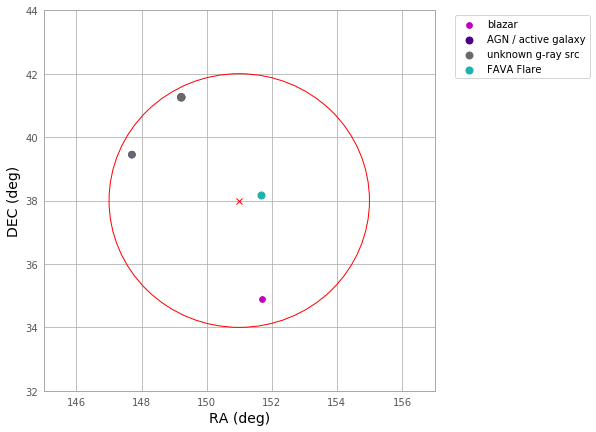

<module 'matplotlib.pyplot' from '/Users/william/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [12]:
ploterrcirc(RA, DEC, ERR, RA1, RA2, DEC1, DEC2)
readfits('nope', './CAIXA_XMM.fits', RA, DEC, RA1, RA2, DEC1, DEC2, ERR, 'XMM')
printout(RA, DEC, ERR, start, stop)
plotsrcs()
plt.show()
plt